### Import

In [222]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [223]:
import math
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd
import seaborn as sns
import os

from functools import reduce
from tqdm import tqdm, tqdm_pandas
# from tqdm._tqdm_notebook import tqdm_notebook

In [224]:
tqdm.pandas()

### Constant

In [225]:
base_path = '../dataset/database_local'
# base_path = '../dataset/database'

In [226]:
flight_runway_file = base_path + '/04_flights_with_runway.csv'
landing_runway_file = base_path + '/04_landing_count_detail.csv'
all_fdm_file = base_path + '/06_all_crucial_fdm.csv'
output_flap_file = base_path + '/07_param_flap.csv'

# Read Data

#### 1. Read All Crucial FDM Flight

In [227]:
all_fdm = pd.read_csv(all_fdm_file, index_col=0)
display(all_fdm.head())
print(all_fdm.shape)

,hbaro_m,hdot_1_mps,flap_te_pos,gs_dev_ddm,gs_mps,loc_dev_ddm,lg_squat_mr,n11_rpm,n12_rpm,n13_rpm,n14_rpm,theta_rad,hralt_m,tas_mps,chi_rad,file
56716,999.1344,-3.73888,NaN,NaN,96.32889,NaN,NaN,34.03125,33.125,33.18750,34.15625,-0.021283,810.768,96.746872,-3.042753,686200104121825.csv
56717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,686200104121825.csv
56718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.021283,810.768,NaN,NaN,686200104121825.csv
56719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,686200104121825.csv
56720,998.2200,-3.49504,2436.0,-0.33384,96.07167,-0.365736,0.0,34.03125,33.125,33.21875,34.15625,-0.021092,810.768,96.586110,-3.040452,686200104121825.csv


(800, 16)


# Transform Data

### Parameter Function
Determine if a flight is unstable or stable. Steps:
1. Convert `flap_te_pos` to degrees by dividing with 100
2. Unstable condition: `flap_te_pos < 30` for 5s consecutive
    - Search for value < 30, if the next 5 consecutive is still < 30 then unstable, else stable.

In [228]:
list_a = [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]

def find_n_consecutive_flag(flag_list: list, n: int) -> bool:
    if len(flag_list) < n:
        return(False)
    for i in range(len(flag_list) - (n - 1)):
        if flag_list[i] == 0:
            continue
        sum_flag = sum(flag_list[i:i+n])
        if sum_flag == n:
            return(True)
    return(False)

find_n_consecutive_flag(list_a, 5)

True

In [229]:
test = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
find_n_consecutive_flag(test, 5)

False

# Param 1: Flap
- column: flap_te_pos
- unstable if flap_deg < 30

In [230]:
def detect_flap_unstable(df):
    cleaned_flaps = df.flap_te_pos.dropna()
    flap_deg = cleaned_flaps / 100
    sns.lineplot(data=flap_deg.reset_index(drop=True), lw=0.25, color='#1f77b4')
    flap_flag = list(flap_deg < 30)
    is_unstable = find_n_consecutive_flag(flap_flag, n=5)
    return int(is_unstable)

### Detect for All FDM

100%|██████████| 5/5 [00:00<00:00, 37.01it/s]


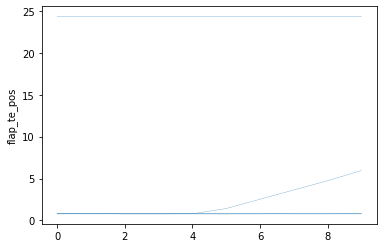

In [231]:
unstable_detection = all_fdm.groupby('file').progress_apply(detect_flap_unstable)

In [232]:
unstable_detection_df = pd.DataFrame(unstable_detection, columns=['flap'])
unstable_detection_df.head()

,flap
file,
686200104121245.csv,1
686200104121532.csv,1
686200104121825.csv,1
686200104130429.csv,1
686200104130652.csv,1


In [233]:
unstable_detection_df.to_csv(output_flap_file)

# Param 2: Gamma

### Parameter Function
- Find gamma value using `gamma_rad = arcsin(hdot_1_mps/gs_mps)`
- Convert rad to degree
- up_bound = -1.0, lw_bound = -5.0

In [234]:
all_fdm.gs_mps.dropna()

56716      96.328890
56720      96.071670
56724      96.071670
56728      95.943060
56732      95.750145
             ...    
146332    109.511415
146336    109.382805
146340    109.318500
146344    109.318500
146348    109.189890
Name: gs_mps, Length: 200, dtype: float64

In [235]:
all_fdm.hdot_1_mps.dropna()

56716     -3.73888
56720     -3.49504
56724     -3.41376
56728     -3.25120
56732     -3.41376
            ...   
146332   -11.46048
146336   -11.05408
146340   -11.37920
146344   -10.89152
146348   -11.05408
Name: hdot_1_mps, Length: 200, dtype: float64

In [236]:
def detect_gamma_unstable(df):
    """
    Return 1 if flight is unstable or 0 if flight is stable, based on gamma parameter.
    gamma_rad = arcsin(hdot_1_mps/gs_mps)
    Unstable if gamma_deg > -1.0 or gamma_deg < -5.0
    """
    # Clean df
    cleaned_gs_mps = df.gs_mps.dropna()
    cleaned_hdot = df.hdot_1_mps.dropna()
    
    # Convert to gamma_deg
    gamma_rad = np.arcsin(cleaned_hdot/cleaned_gs_mps)
    gamma_deg = gamma_rad.map(math.degrees)
    
    # Flag unstable flight
    gamma_flag = list((gamma_deg > -1) | (gamma_deg < -5))
    
    # Display plot
    sns.lineplot(data=gamma_deg.reset_index(drop=True), lw=0.25, color='#1f77b4')
    
    # Determine unstable or stable
    is_unstable = find_n_consecutive_flag(gamma_flag, 5)
    return int(is_unstable)

In [237]:
a

array([ 0.        ,  0.01098633,  0.02197267,  0.02197076,  0.032959  ,
        0.03295709,  0.06591609,  0.06591609,  0.04394342,  0.02197267,
        0.        , -0.02197267, -0.03295709, -0.04394342, -0.04394533,
       -0.05492976, -0.04394342, -0.04394342, -0.04394533, -0.04394342,
       -0.02197267, -0.02197076, -0.02197267,  0.01098633,  0.        ,
        0.02197076,  0.02197267,  0.02197267,  0.02197076,  0.032959  ,
        0.01098633,  0.01098633,  0.01098443,  0.        ,  0.        ,
       -0.01098443, -0.01098633, -0.01098633, -0.02197267, -0.01098633,
       -0.01098443, -0.01098633, -0.01098633, -0.01098633,  0.        ,
        0.        ,  0.01098633,  0.01098633,  0.02197076,  0.032959  ,
        0.04394342,  0.032959  ,  0.03295709,  0.02197267,  0.03295709,
        0.02197267,  0.01098633,  0.        ,  0.        ,  0.        ,
       -0.01098633,  0.        ,  0.01098633,  0.01098633,  0.02197076,
        0.01098633,  0.02197267,  0.01098633,  0.01098443,  0.01

0

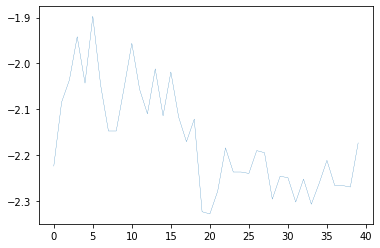

In [238]:
detect_gamma_unstable(all_fdm[all_fdm['file'] == '686200104121825.csv'])

100%|██████████| 5/5 [00:00<00:00, 22.91it/s]


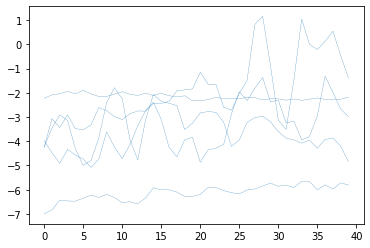

In [239]:
unstable_gamma_detection = all_fdm.groupby('file').progress_apply(detect_gamma_unstable)

1

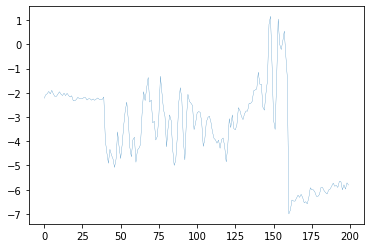

In [240]:
detect_gamma_unstable(all_fdm)

In [241]:
unstable_detection_df['gamma'] = unstable_gamma_detection
unstable_detection_df

,flap,gamma
file,,
686200104121245.csv,1,0
686200104121532.csv,1,1
686200104121825.csv,1,0
686200104130429.csv,1,0
686200104130652.csv,1,1


# Param 3: Glide Slope
- Convert `gs_dev_ddm` to dot using `gs_dev_ddm * 1.0 / 0.0875`
- max_gs_dev_dot = 1, min_gs_dev_dot = -1


- Convert `gs_dev_ddm` to dot using `gs_dev_ddm * 1.0 / 0.0875`
- max_gs_dev_dot = 1, min_gs_dev_dot = -1

In [242]:
def detect_glide_slope_unstable(df):
    """
    Return 1 if flight is unstable or 0 if flight is stable, based on gs_dev_ddm.
    gs_dev_dot = gs_dev_ddm * ( 1 / 0.0875)
    Unstable if gs_dev_dot > 1 or gs_dev_dot < -1
    """
    # Clean df
    cleaned_gs_dev_ddm = df.gs_dev_ddm.dropna()
    
    # Convert ddm to dot
    ddm_to_dot = 1.0 / 0.0875
    gs_dev_dot = cleaned_gs_dev_ddm * ddm_to_dot
    
    # Flag unstable flight
    unstable_flag = list((gs_dev_dot > 1) | (gs_dev_dot < -1))

    # Determine unstable or stable
    is_unstable = find_n_consecutive_flag(unstable_flag, 5)
    
    # Display plot
    line_color = 'red' if is_unstable else '#1f77b4'
    sns.lineplot(data=gs_dev_dot.reset_index(drop=True), lw=0.25, color=line_color)
    
    return int(is_unstable)

1

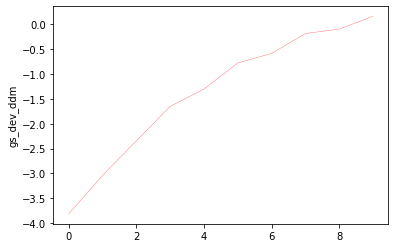

In [243]:
sample_df = all_fdm[all_fdm['file'] == '686200104121825.csv']
detect_glide_slope_unstable(sample_df)

100%|██████████| 5/5 [00:00<00:00, 38.47it/s]


,flap,gamma,glide
file,,,
686200104121245.csv,1,0,1
686200104121532.csv,1,1,0
686200104121825.csv,1,0,1
686200104130429.csv,1,0,1
686200104130652.csv,1,1,0


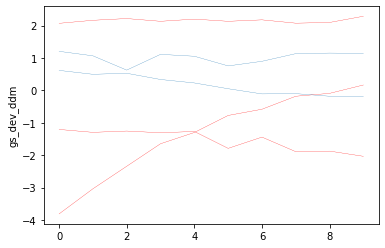

In [244]:
unstable_glide_detection = all_fdm.groupby('file').progress_apply(detect_glide_slope_unstable)
unstable_detection_df['glide'] = unstable_glide_detection
unstable_detection_df

In [245]:
unstable_detection_df['glide'] = unstable_glide_detection
unstable_detection_df

,flap,gamma,glide
file,,,
686200104121245.csv,1,0,1
686200104121532.csv,1,1,0
686200104121825.csv,1,0,1
686200104130429.csv,1,0,1
686200104130652.csv,1,1,0


# Param 4: Altitude Rate
- max_hdot_mps = -5.08

In [246]:
def detect_altitude_unstable(df):
    """
    Return 1 if flight is unstable or 0 if flight is stable, based on hdot_1_mps.
    Unstable if hdot_1_mps > -5.08
    """
    # Clean df
    cleaned_hdot_1_mps = df.hdot_1_mps.dropna()
    
    # Flag unstable flight
    unstable_flag = list(cleaned_hdot_1_mps > -5.08)

    # Determine unstable or stable
    is_unstable = find_n_consecutive_flag(unstable_flag, 5)
    
    # Display plot
    line_color = 'red' if is_unstable else '#1f77b4'
    sns.lineplot(data=cleaned_hdot_1_mps.reset_index(drop=True), lw=0.25, color=line_color)
    
    return int(is_unstable)

1

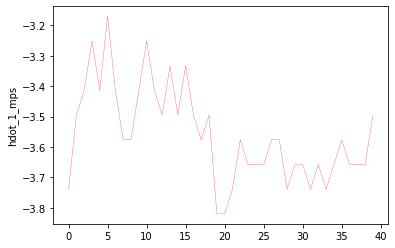

In [247]:
sample_df = all_fdm[all_fdm['file'] == '686200104121825.csv']
detect_altitude_unstable(sample_df)

In [248]:
sample_df.columns

Index(['hbaro_m', 'hdot_1_mps', 'flap_te_pos', 'gs_dev_ddm', 'gs_mps',
       'loc_dev_ddm', 'lg_squat_mr', 'n11_rpm', 'n12_rpm', 'n13_rpm',
       'n14_rpm', 'theta_rad', 'hralt_m', 'tas_mps', 'chi_rad', 'file'],
      dtype='object')

100%|██████████| 5/5 [00:00<00:00, 41.00it/s]


,flap,gamma,glide,altitude
file,,,,
686200104121245.csv,1,0,1,0
686200104121532.csv,1,1,0,1
686200104121825.csv,1,0,1,1
686200104130429.csv,1,0,1,1
686200104130652.csv,1,1,0,0


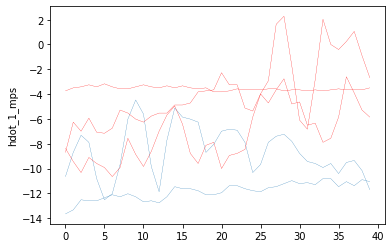

In [249]:
unstable_altitude_detection = all_fdm.groupby('file').progress_apply(detect_altitude_unstable)
unstable_detection_df['altitude'] = unstable_altitude_detection
unstable_detection_df

# Param 5: Localizer
- Using `loc_dev_ddm`
- Convert ddm to dot
- max_loc_dev_dot = 1

In [250]:
def detect_localizer_unstable(df):
    """
    Return 1 if flight is unstable or 0 if flight is stable, based on loc_dev_ddm.
    loc_dev_dot = loc_dev_ddm * (1 / 0.0875)
    Unstable if loc_dev_dot > 1 or loc_dev_dot < -1
    """
    # Clean df
    cleaned_loc_dev_ddm = df.loc_dev_ddm.dropna()
    
    # Convert ddm to dot
    ddm_to_dot = 1.0 / 0.0875
    loc_dev_dot = cleaned_loc_dev_ddm * ddm_to_dot
    
    # Flag unstable flight
    unstable_flag = list((loc_dev_dot > 1) | (loc_dev_dot < -1))

    # Determine unstable or stable
    is_unstable = find_n_consecutive_flag(unstable_flag, 5)
    
    # Display plot
    line_color = 'red' if is_unstable else '#1f77b4'
    sns.lineplot(data=loc_dev_dot.reset_index(drop=True), lw=0.25, color=line_color)
    
    return int(is_unstable)

1

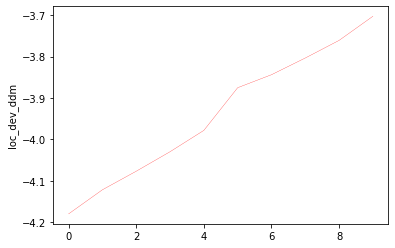

In [251]:
sample_df = all_fdm[all_fdm['file'] == '686200104121825.csv']
detect_localizer_unstable(sample_df)

100%|██████████| 5/5 [00:00<00:00, 45.87it/s]


,flap,gamma,glide,altitude,localizer
file,,,,,
686200104121245.csv,1,0,1,0,1
686200104121532.csv,1,1,0,1,1
686200104121825.csv,1,0,1,1,1
686200104130429.csv,1,0,1,1,1
686200104130652.csv,1,1,0,0,1


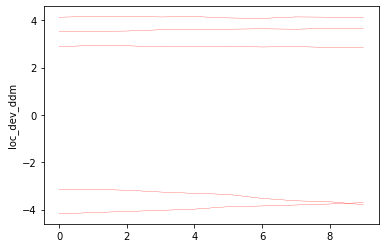

In [252]:
unstable_localizer_detection = all_fdm.groupby('file').progress_apply(detect_localizer_unstable)
unstable_detection_df['localizer'] = unstable_localizer_detection
unstable_detection_df

# Param 6: Thrust
- Using n1_rpm value: `n1_rpm = (n11_rpm + n12_rpm + n13_rpm + n14_rpm) / 4`
- min_r1_rpm = 30

In [253]:
sample_df.columns

Index(['hbaro_m', 'hdot_1_mps', 'flap_te_pos', 'gs_dev_ddm', 'gs_mps',
       'loc_dev_ddm', 'lg_squat_mr', 'n11_rpm', 'n12_rpm', 'n13_rpm',
       'n14_rpm', 'theta_rad', 'hralt_m', 'tas_mps', 'chi_rad', 'file'],
      dtype='object')

In [254]:
def detect_thrust_unstable(df):
    """
    Return 1 if flight is unstable or 0 if flight is stable, based on n1_rpm.
    n1_rpm = (n11_rpm + n12_rpm + n13_rpm + n14_rpm) / 4
    Unstable if n1_rpm < 30
    """
    # Clean df
    cleaned_n11_rpm = df.n11_rpm.dropna()
    cleaned_n12_rpm = df.n12_rpm.dropna()
    cleaned_n13_rpm = df.n13_rpm.dropna()
    cleaned_n14_rpm = df.n14_rpm.dropna()
    
    # Find n1_rpm
    n1_rpm = (cleaned_n11_rpm + cleaned_n12_rpm + cleaned_n13_rpm + cleaned_n14_rpm) / 4
    
    # Flag unstable flight
    unstable_flag = list(n1_rpm < 30)

    # Determine unstable or stable
    is_unstable = find_n_consecutive_flag(unstable_flag, 5)
    
    # Display plot
    line_color = 'red' if is_unstable else '#1f77b4'
    sns.lineplot(data=n1_rpm.reset_index(drop=True), lw=0.25, color=line_color)
    
    return int(is_unstable)

0

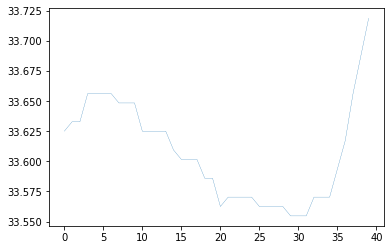

In [255]:
sample_df = all_fdm[all_fdm['file'] == '686200104121825.csv']
detect_thrust_unstable(sample_df)

100%|██████████| 5/5 [00:00<00:00, 25.50it/s]


,flap,gamma,glide,altitude,localizer,thrust
file,,,,,,
686200104121245.csv,1,0,1,0,1,0
686200104121532.csv,1,1,0,1,1,0
686200104121825.csv,1,0,1,1,1,0
686200104130429.csv,1,0,1,1,1,0
686200104130652.csv,1,1,0,0,1,0


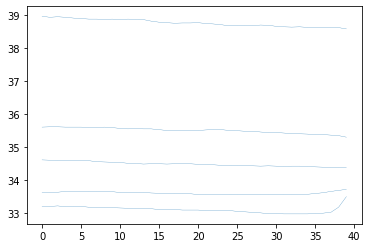

In [256]:
unstable_thrust_detection = all_fdm.groupby('file').progress_apply(detect_thrust_unstable)
unstable_detection_df['thrust'] = unstable_thrust_detection
unstable_detection_df

# Param 7: True Airspeed
- Column: tas_mps
- For B747: min_tas_mps = 72.5 m/s & max_tas_mps = 82.8 m/s

In [257]:
sample_df.columns

Index(['hbaro_m', 'hdot_1_mps', 'flap_te_pos', 'gs_dev_ddm', 'gs_mps',
       'loc_dev_ddm', 'lg_squat_mr', 'n11_rpm', 'n12_rpm', 'n13_rpm',
       'n14_rpm', 'theta_rad', 'hralt_m', 'tas_mps', 'chi_rad', 'file'],
      dtype='object')

In [258]:
def detect_airspeed_unstable(df):
    """
    Return 1 if flight is unstable or 0 if flight is stable, based on tas_mps.
    for B747: unstable if tas_mps < 72.5 or tas_mps > 82.8
    """
    # Clean df
    cleaned_tas_mps = df.tas_mps.dropna()
    
    # Flag unstable flight
    unstable_flag = list((cleaned_tas_mps < 72.5) | (cleaned_tas_mps > 82.8))

    # Determine unstable or stable
    is_unstable = find_n_consecutive_flag(unstable_flag, 5)
    
    # Display plot
    line_color = 'red' if is_unstable else '#1f77b4'
    sns.lineplot(data=cleaned_tas_mps.reset_index(drop=True), lw=0.25, color=line_color)
    
    return int(is_unstable)

1

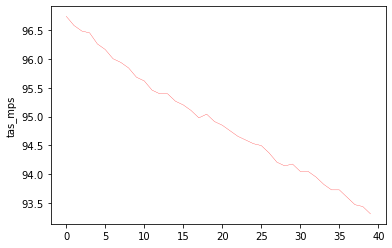

In [259]:
sample_df = all_fdm[all_fdm['file'] == '686200104121825.csv']
detect_airspeed_unstable(sample_df)

100%|██████████| 5/5 [00:00<00:00, 25.40it/s]


,flap,gamma,glide,altitude,localizer,thrust,airspeed
file,,,,,,,
686200104121245.csv,1,0,1,0,1,0,1
686200104121532.csv,1,1,0,1,1,0,1
686200104121825.csv,1,0,1,1,1,0,1
686200104130429.csv,1,0,1,1,1,0,1
686200104130652.csv,1,1,0,0,1,0,1


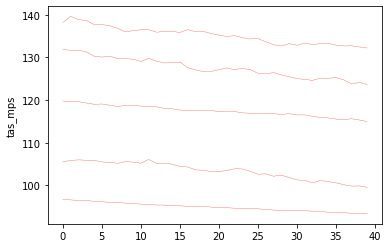

In [260]:
unstable_airspeed_detection = all_fdm.groupby('file').progress_apply(detect_airspeed_unstable)
unstable_detection_df['airspeed'] = unstable_airspeed_detection
unstable_detection_df

# Param 8: Pitch Angle
- column: theta_rad
- convert to theta_deg
- sum of difference = sum(np.diff(theta_deg)) 
- max_cumsum_theta_deg = 5

In [261]:
theta_deg = sample_df.theta_rad.dropna().map(math.degrees)

In [262]:
pd.Series(cumsum_theta_deg).rolling(5).sum()

0          NaN
1          NaN
2          NaN
3          NaN
4     0.845921
        ...   
70    0.373520
71    0.406477
72    0.439438
73    0.483383
74    0.571270
Length: 75, dtype: float64

In [263]:
def detect_pitch_unstable(df):
    """
    Return 1 if flight is unstable or 0 if flight is stable, based on theta_rad.
    Unstable if sum of difference on theta_deg (cumsum_theta_deg)  > 5
    """
    # Clean df
    cleaned_theta_rad = df.theta_rad.dropna()
    
    # Convert to deg
    theta_deg = cleaned_theta_rad.map(math.degrees)
    
    # Find cummulative sum
    diff_theta_deg = pd.Series(abs(np.diff(theta_deg)))
    cumsum_theta_deg = diff_theta_deg.rolling(5).sum()
    
    # Flag unstable flight
    unstable_flag = list(cumsum_theta_deg > 5)

    # Determine unstable or stable
    is_unstable = find_n_consecutive_flag(unstable_flag, 5)
    
    # Display plot
    line_color = 'red' if is_unstable else '#1f77b4'
    sns.lineplot(data=cumsum_theta_deg, lw=0.25, color=line_color)
    
    return int(is_unstable)

0

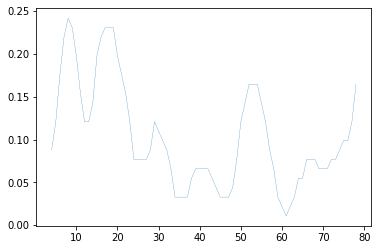

In [264]:
sample_df = all_fdm[all_fdm['file'] == '686200104121825.csv']
detect_pitch_unstable(sample_df)

100%|██████████| 5/5 [00:00<00:00, 27.02it/s]


,flap,gamma,glide,altitude,localizer,thrust,airspeed,pitch
file,,,,,,,,
686200104121245.csv,1,0,1,0,1,0,1,0
686200104121532.csv,1,1,0,1,1,0,1,0
686200104121825.csv,1,0,1,1,1,0,1,0
686200104130429.csv,1,0,1,1,1,0,1,0
686200104130652.csv,1,1,0,0,1,0,1,0


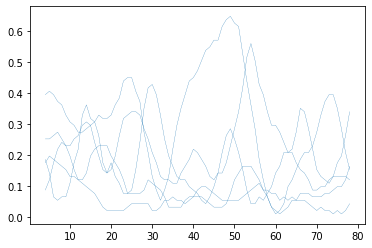

In [265]:
unstable_pitch_detection = all_fdm.groupby('file').progress_apply(detect_pitch_unstable)
unstable_detection_df['pitch'] = unstable_pitch_detection
unstable_detection_df

# Param 9: Track Angle
- column: chi_rad
- Convert rad to degrees, mod 360 -> math.degrees(rad) % 360
- up_bound = 305, lw_bound = 295

In [266]:
def detect_track_unstable(df):
    """
    Return 1 if flight is unstable or 0 if flight is stable, based on chi_rad.
    Convert to chi_deg then mod by 360.
    Unstable if chi_deg > 305 or chi_deg < 295
    """
    # Clean df
    cleaned_chi_rad = df.chi_rad.dropna()
    
    # Convert to chi_deg
    chi_deg = cleaned_chi_rad * math.degrees(1) % 360
    
    # Flag unstable flight
    unstable_flag = list((chi_deg < 295) | (chi_deg > 305))

    # Determine unstable or stable
    is_unstable = find_n_consecutive_flag(unstable_flag, 5)
    
    # Display plot
    line_color = 'red' if is_unstable else '#1f77b4'
    sns.lineplot(data=chi_deg.reset_index(drop=True), lw=0.25, color=line_color)
    
    return int(is_unstable)

1

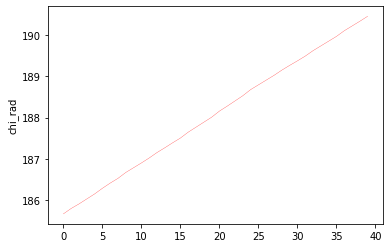

In [267]:
sample_df = all_fdm[all_fdm['file'] == '686200104121825.csv']
detect_track_unstable(sample_df)

100%|██████████| 5/5 [00:00<00:00, 28.21it/s]


,flap,gamma,glide,altitude,localizer,thrust,airspeed,pitch,track
file,,,,,,,,,
686200104121245.csv,1,0,1,0,1,0,1,0,1
686200104121532.csv,1,1,0,1,1,0,1,0,0
686200104121825.csv,1,0,1,1,1,0,1,0,1
686200104130429.csv,1,0,1,1,1,0,1,0,1
686200104130652.csv,1,1,0,0,1,0,1,0,1


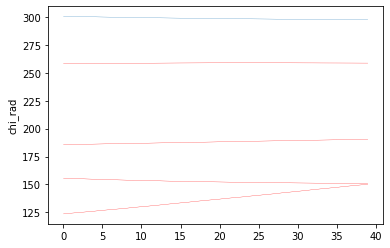

In [268]:
unstable_track_detection = all_fdm.groupby('file').progress_apply(detect_track_unstable)
unstable_detection_df['track'] = unstable_track_detection
unstable_detection_df

# Param 10: Landing Gear
- column: lg_squat_mr
- unstable if ????

Notes: for sampling, after clean df add shift accoring to sampling rate

In [269]:
def detect_lgear_unstable(df):
    """
    Return 1 if flight is unstable or 0 if flight is stable, based on lg_squat_mr.
    Unstable if average for 5 seconds > 0.8
    """
    # Clean df
    cleaned_lg_squat_mr = df.lg_squat_mr.dropna()
    
    # Average value for 5 second
    avg_lg_squat_mr = cleaned_lg_squat_mr.rolling(5).mean()
    
    # Flag window cummulative average
    unstable_flag = list(avg_lg_squat_mr > 0.8)

    # Determine unstable or stable
    is_unstable = find_n_consecutive_flag(unstable_flag, 5)
    
    # Display plot
    color = 'red' if is_unstable else '#1f77b4'
    plt.plot(cleaned_lg_squat_mr.reset_index(drop=True), 'o', markersize=0.5, color=color)
    
    return int(is_unstable)

0

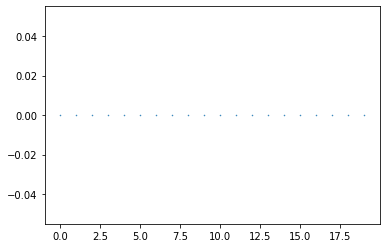

In [270]:
sample_df = all_fdm[all_fdm['file'] == '686200104121825.csv']
detect_lgear_unstable(sample_df)

100%|██████████| 5/5 [00:00<00:00, 22.49it/s]


,flap,gamma,glide,altitude,localizer,thrust,airspeed,pitch,track,lgear
file,,,,,,,,,,
686200104121245.csv,1,0,1,0,1,0,1,0,1,0
686200104121532.csv,1,1,0,1,1,0,1,0,0,0
686200104121825.csv,1,0,1,1,1,0,1,0,1,0
686200104130429.csv,1,0,1,1,1,0,1,0,1,0
686200104130652.csv,1,1,0,0,1,0,1,0,1,0


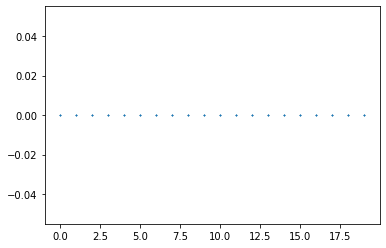

In [271]:
unstable_lgear_detection = all_fdm.groupby('file').progress_apply(detect_lgear_unstable)
unstable_detection_df['lgear'] = unstable_lgear_detection
unstable_detection_df

## Export to CSV

In [272]:
unstable_detection_df.to_csv(base_path + '/07_unstable_detection_df', index=False)